In [1]:
# IMPORTANDO LIBRERIAS

import tensorflow_datasets as tfds
import math
import tensorflow as tf

2025-10-12 16:21:42.804995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 16:21:42.805716: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 16:21:42.814698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 16:21:42.825286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760300502.844580 2374555 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760300502.84

In [2]:
# Cargando nuestro dataset
data, metadata = tfds.load('mnist', as_supervised=True, with_info=True)

2025-10-12 16:21:44.777729: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Funcion para normalizar nuestro dataset
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255 #Aqui lo pasa de 0-255 a 0-1
  return images, labels

In [4]:
# Dividimos nuestro dataset
train, test = data['train'], data['test']

In [5]:
# Guardamos los valores posibles de clasificacion
labels = metadata.features['label'].names

In [6]:
#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
train = train.map(normalize)
test = test.map(normalize)

In [7]:
# Cargamos a memoria para mas rapidez de entrenamiento
train = train.cache()
test = test.cache()

In [8]:
# Creamos el modelo
model = tf.keras.Sequential([

  tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu' ),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

In [9]:
# Compilamos el modelo
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
train_size = metadata.splits["train"].num_examples
test_size = metadata.splits["test"].num_examples

#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
BATCH_SIZE = 32

In [11]:
#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
train = train.repeat().shuffle(train_size).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [12]:
%time history = model.fit(train, epochs=5, validation_data=test, steps_per_epoch= math.ceil(train_size/BATCH_SIZE), verbose=1 )

Epoch 1/5


2025-10-12 16:21:45.789332: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9111 - loss: 0.2855 - val_accuracy: 0.9772 - val_loss: 0.0758
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9666 - loss: 0.1121 - val_accuracy: 0.9807 - val_loss: 0.0627
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9744 - loss: 0.0837 - val_accuracy: 0.9859 - val_loss: 0.0494
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9790 - loss: 0.0704 - val_accuracy: 0.9869 - val_loss: 0.0481
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9804 - loss: 0.0647 - val_accuracy: 0.9881 - val_loss: 0.0453
CPU times: user 3min 17s, sys: 16.6 s, total: 3min 34s
Wall time: 1min 2s


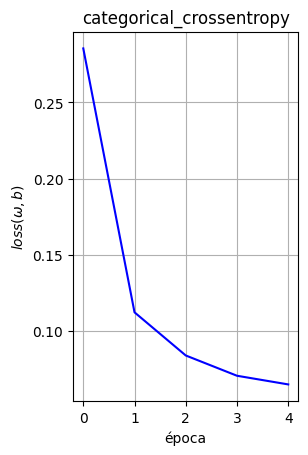

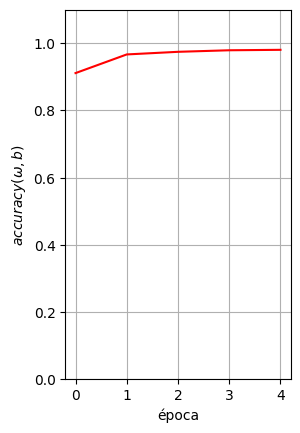

In [13]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'], 'b',label='error')
plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$loss(\omega, b)$')
plt.grid(True)
#plt.legend(loc='upper right')
plt.show()

plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'], 'r',label='precisión')
#plt.title(u'categorical_crossentropy')
plt.xlabel(u'época')
plt.ylabel(r'$accuracy(\omega, b)$')
plt.ylim([0,1.1])
plt.grid(True)
#plt.legend(loc='lower right')
plt.show()

In [14]:
# Guardamos nuestro modelo
model.save('numeros_CNN.h5')

In [15]:
# Creando una carpeta de salida
import os

if not os.path.exists("output"):
  !mkdir "output"

In [16]:
%pip install tensorflowjs

Note: you may need to restart the kernel to use updated packages.


In [17]:
!tensorflowjs_converter --input_format=keras ./numeros_CNN.h5 ./output/

2025-10-12 16:22:49.247259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760300569.258745 2374904 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760300569.262224 2374904 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760300569.272384 2374904 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760300569.272406 2374904 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760300569.272409 2374904 computation_placer.cc:177] computation placer alr